<a href="https://colab.research.google.com/github/maianhtran2005/Project_AI/blob/main/Clean_chunked_filtered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 2. Đọc file JSONL
path = "/content/drive/MyDrive/AI/data_completion.jsonl"
df = pd.read_json(path, lines=True)
print("Số mẫu ban đầu:", len(df))
print(df.head())

# 3. Làm sạch text
def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

df["prompt"] = df["prompt"].apply(clean_text)
df["completion"] = df["completion"].apply(clean_text)

# Bỏ dòng lỗi
df = df[df["completion"] != ""]
df = df.drop_duplicates(subset=["prompt", "completion"])
print("Sau khi làm sạch:", len(df))

# 4. Chunk completion nếu quá dài
def chunk_completion(row, max_len=512):
    prompt, comp = row["prompt"], row["completion"]
    chunks = []
    if len(comp) > max_len:
        for i in range(0, len(comp), max_len):
            comp_chunk = comp[i:i+max_len]
            chunks.append({"prompt": prompt, "completion": comp_chunk})
    else:
        chunks.append({"prompt": prompt, "completion": comp})
    return chunks

rows = []
for _, row in df.iterrows():
    rows.extend(chunk_completion(row))

df = pd.DataFrame(rows)
print("Sau khi chunk:", len(df))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Số mẫu ban đầu: 6275
                                              prompt  \
0  Summarize the following article:\n\nBy . Antho...   
1  Summarize the following article:\n\nthem, we u...   
2  Summarize the following article:\n\nUNITED NAT...   
3  Summarize the following article:\n\neconomic d...   
4  Summarize the following article:\n\nfore, pose...   

                                          completion  
0   John and . Audrey Cook were discovered alongs...  
1   John and . Audrey Cook were discovered alongs...  
2   NEW: Libya can serve as example of cooperatio...  
3   NEW: Libya can serve as example of cooperatio...  
4   NEW: Libya can serve as example of cooperatio...  
Sau khi làm sạch: 6275
Sau khi chunk: 6501


Ngưỡng cắt: prompt ≤ 3042.0, completion ≤ 471.0
Sau khi lọc outlier: 6184


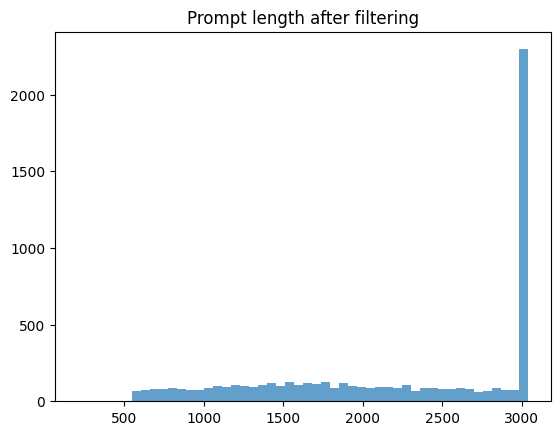

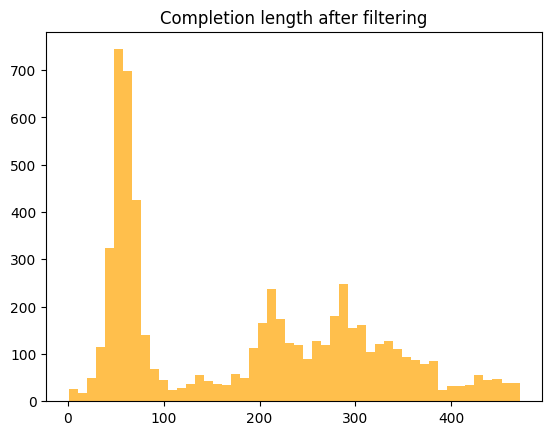

In [8]:
# 5. Thêm cột độ dài
df["prompt_len"] = df["prompt"].str.len()
df["completion_len"] = df["completion"].str.len()

# 6. Lọc outlier theo percentile (giữ dưới 95th percentile)
prompt_p95 = df["prompt_len"].quantile(0.95)
comp_p95 = df["completion_len"].quantile(0.95)

df = df[(df["prompt_len"] <= prompt_p95) & (df["completion_len"] <= comp_p95)]
print(f"Ngưỡng cắt: prompt ≤ {prompt_p95}, completion ≤ {comp_p95}")
print("Sau khi lọc outlier:", len(df))

# 7. Visual lại để kiểm tra
plt.hist(df["prompt_len"], bins=50, alpha=0.7)
plt.title("Prompt length after filtering")
plt.show()

plt.hist(df["completion_len"], bins=50, alpha=0.7, color="orange")
plt.title("Completion length after filtering")
plt.show()

# 8. Chia train/val
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

# 9. Lưu JSONL
def save_jsonl(df, filename):
    with open(filename, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            f.write(pd.Series(row[["prompt","completion"]]).to_json(force_ascii=False))
            f.write("\n")

save_jsonl(train_df, "/content/drive/MyDrive/AI/train_clean_chunked_filtered.jsonl")
save_jsonl(val_df, "/content/drive/MyDrive/AI/val_clean_chunked_filtered.jsonl")



In [9]:
import pandas as pd

# Đọc file train/val đã clean
train_path = "/content/drive/MyDrive/AI/train_clean_chunked_filtered.jsonl"
val_path = "/content/drive/MyDrive/AI/val_clean_chunked_filtered.jsonl"

train_df = pd.read_json(train_path, lines=True)
val_df = pd.read_json(val_path, lines=True)

print("Số mẫu Train:", len(train_df))
print("Số mẫu Val:", len(val_df))

# Kiểm tra null/trống
print("Train null:", train_df.isnull().sum().to_dict())
print("Val null:", val_df.isnull().sum().to_dict())

# Kiểm tra completion ngắn
train_df["completion_len"] = train_df["completion"].str.len()
val_df["completion_len"] = val_df["completion"].str.len()

print("Min completion len (train):", train_df["completion_len"].min())
print("Min completion len (val):", val_df["completion_len"].min())

# Thống kê phân phối độ dài
print(train_df["completion_len"].describe(percentiles=[0.9, 0.95, 0.99]))
print(val_df["completion_len"].describe(percentiles=[0.9, 0.95, 0.99]))

# Xem vài mẫu dữ liệu
print(train_df.sample(3))

Số mẫu Train: 5565
Số mẫu Val: 619
Train null: {'prompt': 0, 'completion': 0}
Val null: {'prompt': 0, 'completion': 0}
Min completion len (train): 1
Min completion len (val): 3
count    5565.000000
mean      185.652111
std       126.557894
min         1.000000
50%       195.000000
90%       358.000000
95%       404.000000
99%       455.000000
max       471.000000
Name: completion_len, dtype: float64
count    619.000000
mean     179.466882
std      120.388799
min        3.000000
50%      195.000000
90%      340.000000
95%      379.300000
99%      453.280000
max      471.000000
Name: completion_len, dtype: float64
                                                 prompt  \
2554  Summarize the following article: (CNN) -- Roma...   
5497  Summarize the following article: o represent a...   
1978  Summarize the following article: on the proper...   

                                             completion  completion_len  
2554  Roma move up to sixth place in the Serie A tab...             2